# Spam filter using Naive Bayes

We're going to study the practical side of the Naive Bayes algorithm by building a spam filter for SMS messages. We will be doing are calculations based on the formulas in the image below.

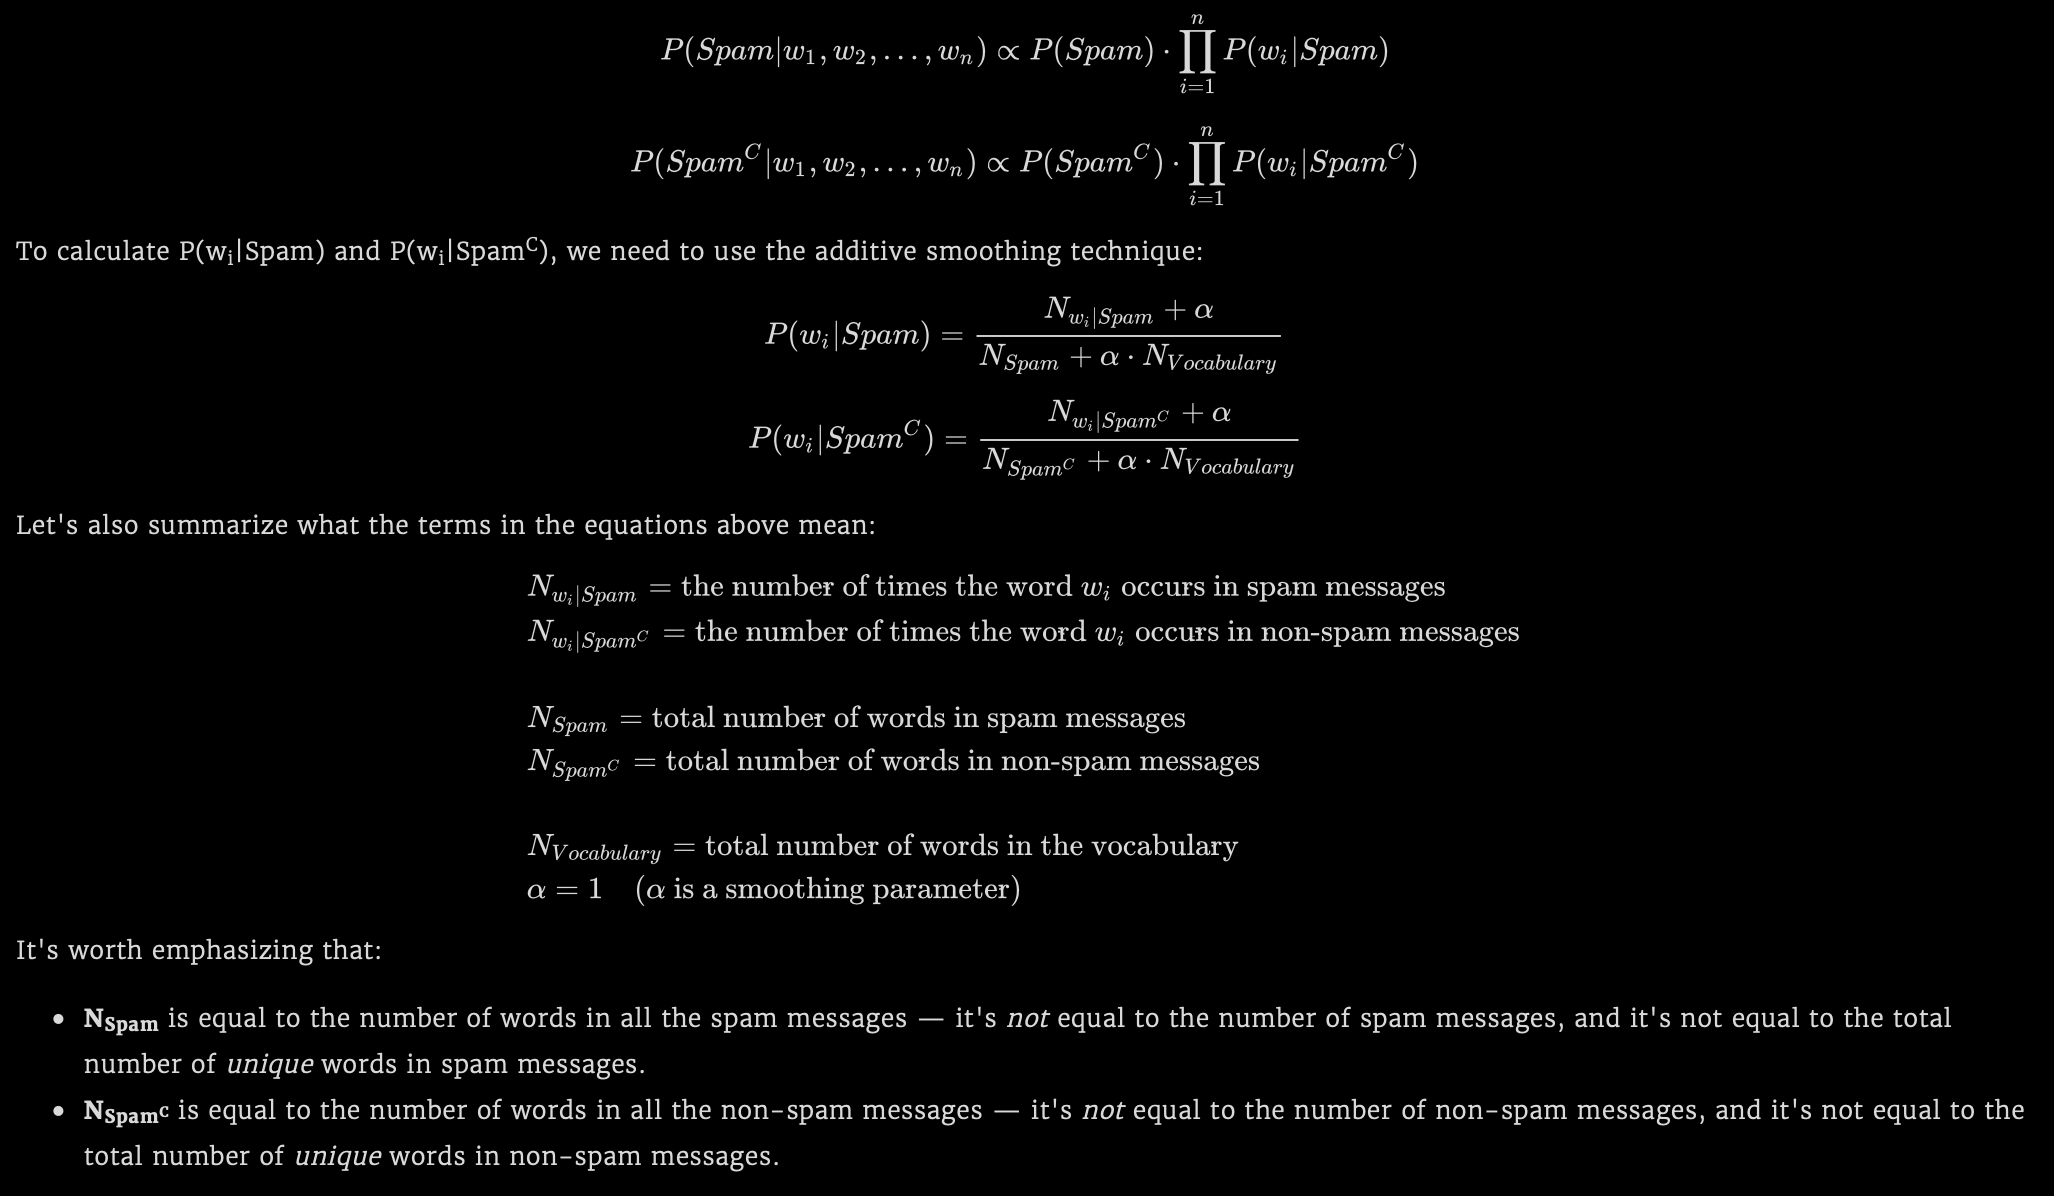

### Exploring the data

In [1]:
import pandas as pd
import numpy as np

sms_spam = pd.read_csv("SMSSpamCollection", sep = '\t', header = None, names=['Label', 'SMS'])

In [2]:
sms_spam.head(3)

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [3]:
sms_spam.tail(3)

,Label,SMS
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [4]:
print(sms_spam.shape)
print()
print(sms_spam['Label'].value_counts(normalize = True))

(5572, 2)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64


### Training and Test Set

Before creating the algorithm, we will first create the test.
We split the data set into a random 80% for training the algorithm and the rest 20% for testing.

In [5]:
sms_spam_random = sms_spam.sample(frac = 1 , random_state=1)
training = sms_spam_random.iloc[:4458]
test = sms_spam_random.iloc[4458:]

In [6]:
print(training.shape, test.shape, sms_spam_random.shape)
print(training['Label'].value_counts(normalize = True),'\n',sms_spam_random['Label'].value_counts(normalize = True))

(4458, 2) (1114, 2) (5572, 2)
ham     0.86541
spam    0.13459
Name: Label, dtype: float64 
 ham     0.865937
spam    0.134063
Name: Label, dtype: float64


In [7]:
training.head(3)

,Label,SMS
1078,ham,"Yep, by the pretty sculpture"
4028,ham,"Yes, princess. Are you going to make me moan?"
958,ham,Welp apparently he retired


In [8]:
#Let's reset the indexes
training = training.reset_index(drop=True)
test = test.reset_index(drop=True)

#And check the % of ham / spam in both new data frames
print(training['Label'].value_counts(normalize = True),
      '\n',test['Label'].value_counts(normalize = True))

ham     0.86541
spam    0.13459
Name: Label, dtype: float64 
 ham     0.868043
spam    0.131957
Name: Label, dtype: float64


### Data cleaning

##### Removing punctuation and lowering case

In [9]:
training2 = training.copy()

In [10]:
#We remove punctuation
training2['SMS'] = training2['SMS'].str.replace('\W', ' ')

#We change all to lowercase
training2['SMS'] = training2['SMS'].str.lower()

In [11]:
training2.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


##### Creating the vocabulary

In [12]:
training3 = training2.copy()

In [13]:
training3['SMS'] = training3['SMS'].str.split()

In [14]:
training3.head(4)

,Label,SMS
0,ham,"[yep, by, the, pretty, sculpture]"
1,ham,"[yes, princess, are, you, going, to, make, me,..."
2,ham,"[welp, apparently, he, retired]"
3,ham,[havent]


In [15]:
training3.tail(2)

,Label,SMS
4456,ham,"[hello, my, boytoy, geeee, i, miss, you, alrea..."
4457,ham,"[wherre, s, my, boytoy]"


In [16]:
vocabulary = []
for row in training3['SMS']:
    for i in row:
        vocabulary.append(i)

print(vocabulary[:10])
print(len(vocabulary))

['yep', 'by', 'the', 'pretty', 'sculpture', 'yes', 'princess', 'are', 'you', 'going']
72427


In [17]:
vocabulary = set(vocabulary)

print(len(vocabulary))
print(list(vocabulary)[:10])

7783
['executive', 'sexual', 'hungry', 'lodge', 'gods', 'lk', 'getzed', 'toclaim', 'reslove', 'x49']


In [18]:
vocabulary = list(vocabulary)

print(vocabulary[:10])
#if we want we could print the whole vocabulary to see what it looks like but it's too long.
#print(vocabulary)

['executive', 'sexual', 'hungry', 'lodge', 'gods', 'lk', 'getzed', 'toclaim', 'reslove', 'x49']


##### Creating the dictionnary of vocabulary frequency

I tried the first coding block below but it didn't work. So I then did it a different way. I left both just to remember.

In [19]:
#This method doesnt work

# word_counts_per_sms = {}
# i = 0
# count = 0

# for elem in vocabulary:                             #'yep'
#     word_counts_per_sms[elem] = [0] * 4457
#     for row in training3['SMS']:                    # [yep, by, hi]
#         for word in row:                            #'yep'
#             if word == elem: word_counts_per_sms[elem][i] += 1
#             else : continue
#         if i == 4457 : 
#             print(i, len(training3['SMS']), count, elem, row[:3])
#             count += 1
#             break
#         i += 1
#     i = 0


Here below is the second method I did, and this time it works.

In [20]:
#Below is another method to build the dictionary

word_counts_per_sms = {unique_word: [0] * len(training3['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training3['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [21]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,executive,sexual,hungry,lodge,gods,lk,getzed,toclaim,reslove,x49,...,rental,xavier,stopped,wil,howdy,agree,misundrstud,08002988890,stuff42moro,water
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
training_set_clean = pd.concat([training3, word_counts], axis=1)

In [23]:
print(training_set_clean.shape)
training_set_clean.head()

(4458, 7785)


,Label,SMS,executive,sexual,hungry,lodge,gods,lk,getzed,toclaim,...,rental,xavier,stopped,wil,howdy,agree,misundrstud,08002988890,stuff42moro,water
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Calculating Constants First

In [24]:
#Calculating p_spam and p_ham
p_spam = sum(training_set_clean['Label'] == 'spam')/ len(training_set_clean['Label'])
p_ham = sum(training_set_clean['Label'] == 'ham')/ len(training_set_clean['Label'])

print(p_spam, p_ham)

0.13458950201884254 0.8654104979811574


In [25]:
#Calculating n_spam and n_ham and n_vocabulary
n_spam = 0
for elem in training3.loc[training3['Label'] == 'spam', 'SMS'] :
    n_spam += len(elem)
    
n_ham = 0
for elem in training3.loc[training3['Label'] == 'ham', 'SMS'] :
    n_ham += len(elem)
    
n_vocabulary = len(vocabulary) 

#Carefull, n_vocabulary is the number of unique words, whereas n_spam is total number
# of words (including non unique) in the spam messages

alpha = 1
    
print(n_spam, n_ham, n_vocabulary)

15190 57237 7783


### Calculating Parameters

Now we want to calculate the parameters p_wi_spam and p_wi_ham. We do our calculations based on the formulas in the picture below.

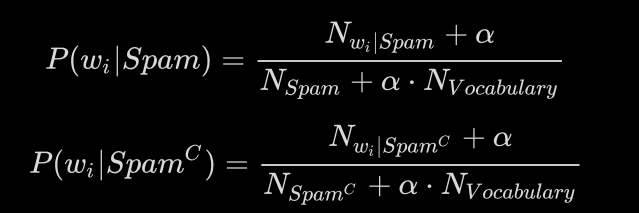

In [26]:
training_spam = training_set_clean[training_set_clean['Label'] == 'spam']
training_ham = training_set_clean[training_set_clean['Label'] == 'ham']

dic_spam = {unique_word: 0 for unique_word in vocabulary}
dic_ham = {unique_word: 0 for unique_word in vocabulary}

for wi in dic_spam :
    n_wi_spam = training_spam[wi].sum()
    p_wi_spam = (n_wi_spam + alpha) / (n_spam + alpha * n_vocabulary)
    dic_spam[wi] = p_wi_spam

for wi in dic_ham :
    n_wi_ham = training_ham[wi].sum()
    p_wi_ham = (n_wi_ham + alpha) / (n_ham + alpha * n_vocabulary)
    dic_ham[wi] = p_wi_ham

In [27]:

print(training_set_clean.shape, training_spam.shape, training_ham.shape)
print()
print(len(dic_spam), len(dic_ham))
print()

#This is to print the first few values of the dictionnary to check that our code above worked properly

from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
n_items_spam = take(10, dic_spam.items())
n_items_ham = take(10, dic_ham.items())

print(n_items_spam,'\n', n_items_ham)


(4458, 7785) (600, 7785) (3858, 7785)

7783 7783

[('executive', 4.3529360553693465e-05), ('sexual', 8.705872110738693e-05), ('hungry', 0.0001305880816610804), ('lodge', 4.3529360553693465e-05), ('gods', 4.3529360553693465e-05), ('lk', 4.3529360553693465e-05), ('getzed', 0.00039176424498324117), ('toclaim', 0.00030470552387585427), ('reslove', 4.3529360553693465e-05), ('x49', 0.0001305880816610804)] 
 [('executive', 3.075976622577668e-05), ('sexual', 1.537988311288834e-05), ('hungry', 0.0001845585973546601), ('lodge', 3.075976622577668e-05), ('gods', 4.6139649338665025e-05), ('lk', 4.6139649338665025e-05), ('getzed', 1.537988311288834e-05), ('toclaim', 1.537988311288834e-05), ('reslove', 3.075976622577668e-05), ('x49', 1.537988311288834e-05)]


### Classifying A New Message

Now that we've calculated all the constants and parameters we need, we can start creating the spam filter. 

In [28]:
import re

def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    #We initialize the values of p_spam_given_message and p_ham_given_message but then they will change depending on words
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in dic_spam:
            p_spam_given_message *= dic_spam[word]
            p_ham_given_message *= dic_ham[word]
        else : continue

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal probabilities, have a human classify this!')

In [29]:
#Now we test some messages that are obvious

test1 = 'WINNER!! This is the secret code to unlock the money: C3421.'
test2 = 'Sounds good, Tom, then see u there'
test3 = 'winner winner'

classify(test1)
classify(test2)
classify(test3)

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam
P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham
P(Spam|message): 4.998409490199666e-08
P(Ham|message): 2.0470489547241915e-10
Label: Spam


### Measuring the Spam Filter's Accuracy

 We'll now try to determine how well the spam filter does on our test set of 1,114 messages. These messages are in the dataframe called test

In [30]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    #We initialize the values of p_spam_given_message and p_ham_given_message but then they will change depending on words
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in dic_spam:
            p_spam_given_message *= dic_spam[word]
            p_ham_given_message *= dic_ham[word]
        else : continue

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [31]:
test['predicted'] = test['SMS'].apply(classify_test_set)

Let's now check the results

In [32]:
test['predicted'].value_counts()

ham                           969
spam                          144
needs human classification      1
Name: predicted, dtype: int64

In [33]:
test.head(20)

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham
5,ham,But my family not responding for anything. Now...,ham
6,ham,U too...,ham
7,ham,Boo what time u get out? U were supposed to ta...,ham
8,ham,Genius what's up. How your brother. Pls send h...,ham
9,ham,I liked the new mobile,ham


In [34]:
correct = 0
total = 1114

for index, elem in test.iterrows():
    if elem['Label'] == elem['predicted'] : correct += 1

In [35]:
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833


We initialy hoped for an accuracy of 80%, but we got 98,7%. This is an amazing result.